#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [6]:
train.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
train.shape

(5881, 562)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [9]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [10]:
train['is_dynamic'] = train['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

### (2) x, y 분리

In [11]:
target = 'is_dynamic'

x = train.drop(columns = target)
y = train[target]

In [12]:
x.drop('Activity', axis=1, inplace=True)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4704, 561), (1177, 561), (4704,), (1177,))

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

- 이진분류: 0이면 정적 1동적

##### base model

In [16]:
nfeatures = x_train.shape[1]
nfeatures

561

In [17]:
model_b = Sequential([Input(shape=(nfeatures,)),
                     Dense(1, activation='sigmoid')])
model_b.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │             562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562 (2.20 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_b.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')

history_b = model_b.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)).history

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0858 - val_loss: 0.0040
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 7.1575e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3406e-04 - val_loss: 6.1420e-04
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6703e-04 - val_loss: 5.3905e-04
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2745e-04 - val_loss: 4.5054e-04
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7777e-04 - val_loss: 4.1319e-04
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1796e-04 - val_loss: 3.8354e-04
Epoch 1

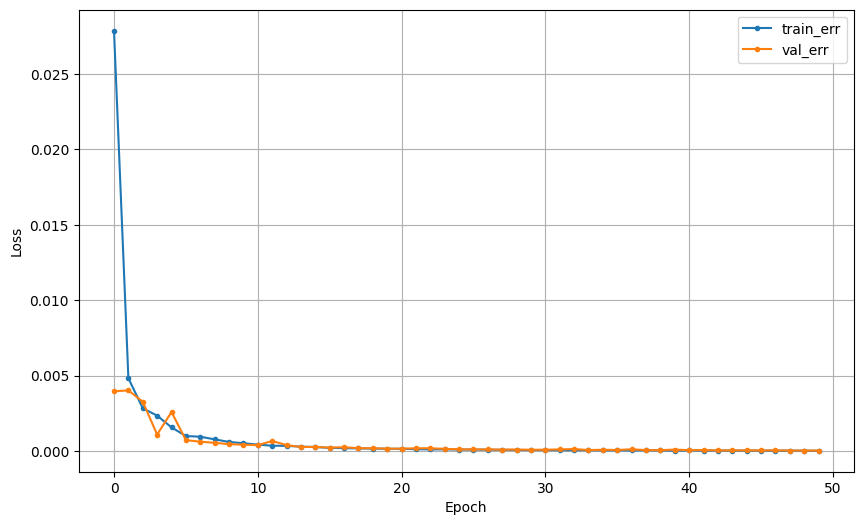

In [19]:
dl_history_plot(history_b)

In [20]:
pred = model_b.predict(x_val)
print(pred[:5])

pred = np.where(pred >= .5, 1, 0)
print(pred[:5])

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.1236330e-08]
 [1.0000000e+00]
 [2.1842204e-09]
 [4.7054971e-10]
 [5.2299554e-10]]
[[0]
 [1]
 [0]
 [0]
 [0]]
[[657   0]
 [  0 520]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



##### 다양한 모델

In [21]:
clear_session()
model2 = Sequential([Input(shape=(nfeatures,)),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    Dense(64, activation='relu'),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dropout(0.2),
                    Dense(16, activation='relu'),
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,849 (1.77 MB)

 Trainable params: 462,849 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

history2 = model2.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1656 - val_loss: 0.0028
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0092 - val_loss: 1.0809e-04
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0079 - val_loss: 5.3264e-05
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0036 - val_loss: 4.2189e-04
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0036 - val_loss: 4.5201e-07
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0039 - val_loss: 6.3479e-07
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0020 - val_loss: 2.0500e-06


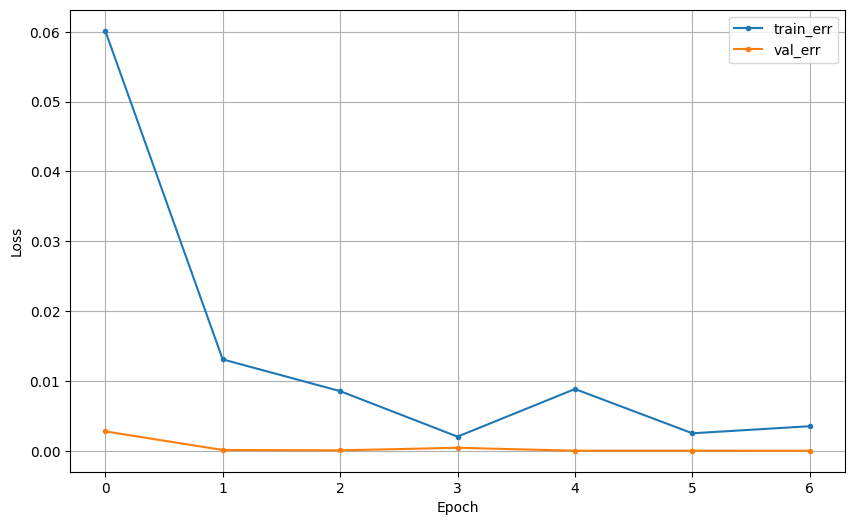

In [23]:
dl_history_plot(history2)

In [24]:
pred2 = model2.predict(x_val)
print(pred2[:5])

pred2 = np.where(pred2 >= .5, 1, 0)
print(pred2[:5])

print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[5.4612672e-16]
 [1.0000000e+00]
 [3.2169956e-18]
 [3.1698521e-18]
 [7.9604657e-19]]
[[0]
 [1]
 [0]
 [0]
 [0]]
[[657   0]
 [  0 520]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



- base model도 정확도 1을 나타내기에 (분류를 잘 함) 복잡한 모델을 사용할 필요없이 base model을 사용하면 된다.

##### feature_importance
- 윤선채님 코드 참조

In [25]:
# # feature importance 통합해 놓은 fi_analysis.pkl 파일 호출
# fi_analysis = joblib.load('fi_analysis.pkl')

In [26]:
# fi_analysis.head()

In [27]:
# # fi_analysis 에서 feature_importance_activity가 높은 상위20개 행의 feature_name 추출
# top_features = fi_analysis.sort_values(by='feature_importance_activity', ascending=False).head(20)['feature_name']
# top_features

In [28]:
# top_features

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [29]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [30]:
static = train[train['is_dynamic'] == 0]

In [31]:
static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0


In [32]:
x_static = static.drop(columns=['Activity', 'is_dynamic'])
y_static = static['Activity']

In [33]:
x_static = scaler.fit_transform(x_static)

In [34]:
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_static, y_static, test_size=0.2, random_state=42)

In [35]:
x_train_s.shape, x_val_s.shape, y_train_s.shape, y_val_s.shape

((2587, 561), (647, 561), (2587,), (647,))

In [36]:
y_train_s = y_train_s.map({'LAYING':0, 'STANDING':1, 'SITTING':2})
y_val_s = y_val_s.map({'LAYING':0, 'STANDING':1, 'SITTING':2})

In [37]:
y_train_s.head()

,Activity
5330,1
2934,1
4683,0
5480,1
1576,0


##### base model - model_s

In [38]:
nfeatures = x_train_s.shape[1]

In [39]:
clear_session()

model_s = Sequential([Input(shape=(nfeatures,)),
                     Dense(3, activation='softmax')])
model_s.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │           1,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_s.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

history_s = model_s.fit(x_train_s, y_train_s, epochs=50, validation_data=(x_val_s, y_val_s)).history

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8446 - val_loss: 0.3647
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3139 - val_loss: 0.2838
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2448 - val_loss: 0.2481
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2094 - val_loss: 0.2011
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1948 - val_loss: 0.1685
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1739 - val_loss: 0.1729
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1745 - val_loss: 0.1418
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 - val_loss: 0.1370
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1342 - val_loss: 0.1267
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1184 - val_loss: 0.1352
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1195 - val_loss: 0.1836
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1270 - val_lo

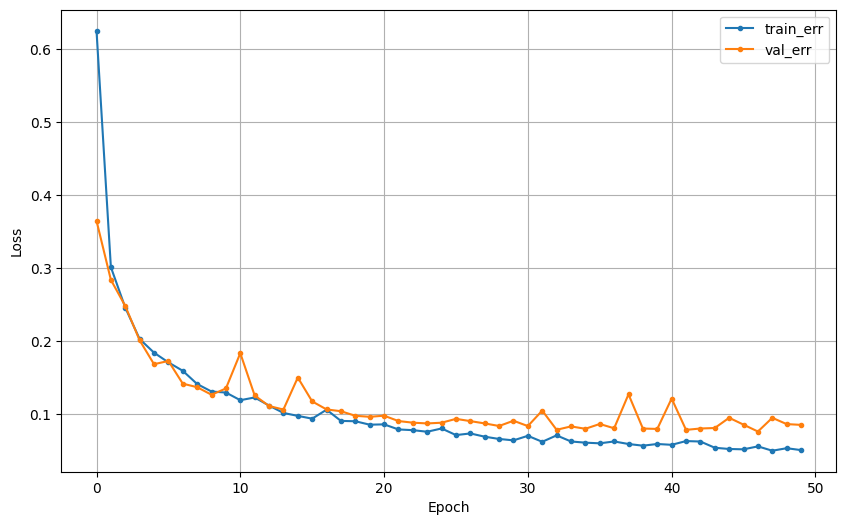

In [41]:
dl_history_plot(history_s)

In [42]:
pred = model_s.predict(x_val_s)
print(pred[:5])

pred = np.where(pred >= .5, 1, 0)
print(pred[:5])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[1.93163659e-03 1.20808894e-03 9.96860266e-01]
 [3.86951433e-06 9.99720335e-01 2.75933708e-04]
 [9.99895275e-01 4.41946149e-14 1.04658575e-04]
 [2.01927294e-04 1.47706300e-01 8.52091730e-01]
 [2.22640592e-04 7.80340075e-01 2.19437316e-01]]
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [43]:
pred_labels = np.argmax(pred, axis=1)

print(confusion_matrix(y_val_s, pred_labels))
print(classification_report(y_val_s, pred_labels))

[[221   0   0]
 [  0 212   9]
 [  0   3 202]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.99      0.96      0.97       221
           2       0.96      0.99      0.97       205

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



##### 다양한 모델

In [44]:
clear_session()

models_2 = Sequential([Input(shape=(nfeatures,)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(3, activation='softmax')])
models_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,883 (1.77 MB)

 Trainable params: 462,883 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 컴파일 및 학습
models_2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historys_2 = models_2.fit(x_train_s, y_train_s, epochs=100, validation_data=(x_val_s, y_val_s), callbacks=[es]).history

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7487 - val_loss: 0.3159
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2548 - val_loss: 0.1919
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1707 - val_loss: 0.1218
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1938 - val_loss: 0.1241
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1522 - val_loss: 0.1668
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1777 - val_loss: 0.0969
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0877 - val_loss: 0.0905
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0711 - val_loss: 0.0828
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1558 - val_loss: 0.2518
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1310 - val_loss: 0.0773
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1472 - val_loss: 0.0985
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss

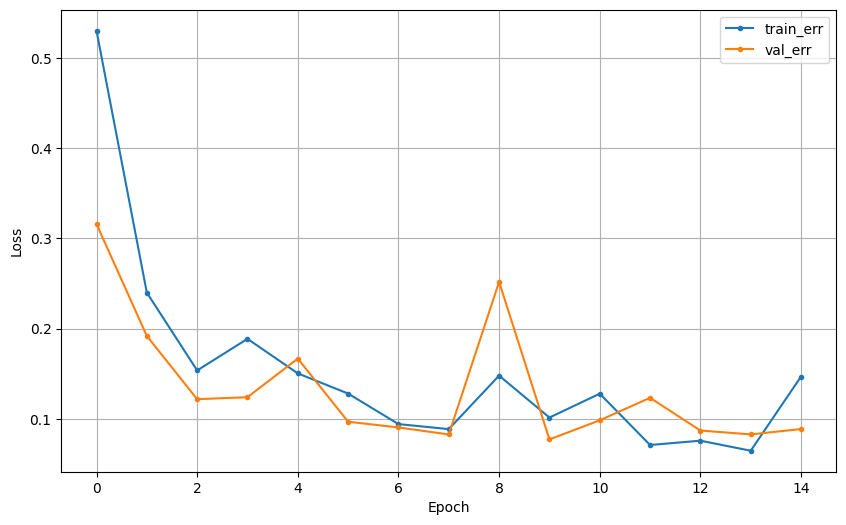

In [46]:
dl_history_plot(historys_2)

In [47]:
preds_2 = models_2.predict(x_val_s)
print(preds_2[:5])

preds_2 = np.where(preds_2 >= .5, 1, 0)
print(preds_2[:5])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[7.4266191e-03 3.1790726e-03 9.8939419e-01]
 [1.7737337e-05 9.9863213e-01 1.3500568e-03]
 [9.9990863e-01 4.8188855e-07 9.0836467e-05]
 [2.8786606e-03 2.0492753e-02 9.7662854e-01]
 [1.0722668e-03 6.8367052e-01 3.1525719e-01]]
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [48]:
pred_labels = np.argmax(preds_2, axis=1)

print(confusion_matrix(y_val_s, pred_labels))
print(classification_report(y_val_s, pred_labels))

[[221   0   0]
 [  0 209  12]
 [  2   3 200]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       221
           1       0.99      0.95      0.97       221
           2       0.94      0.98      0.96       205

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647



In [49]:
clear_session()
models_3 = Sequential([Input(shape=(nfeatures,)),
                    Dense(512, activation='relu'),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    Dense(128, activation='relu'),
                    Dropout(0.3),
                    Dense(64, activation='relu'),
                    Dropout(0.3),
                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    Dense(16, activation='relu'),
                    Dropout(0.3),
                    Dense(3, activation='softmax')])
models_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,883 (1.77 MB)

 Trainable params: 462,883 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# 컴파일 및 학습
models_3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historys_3 = models_3.fit(x_train_s, y_train_s, epochs=100, validation_data=(x_val_s, y_val_s), callbacks=[es]).history

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.1079 - val_loss: 0.8652
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7986 - val_loss: 0.5669
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5920 - val_loss: 0.4850
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5410 - val_loss: 0.4560
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4882 - val_loss: 0.3623
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4539 - val_loss: 0.2868
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3487 - val_loss: 0.2077
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3042 - val_loss: 0.2302
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2442 - val_loss: 0.1735
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2174 - val_loss: 0.1478
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2113 - val_loss: 0.1790
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

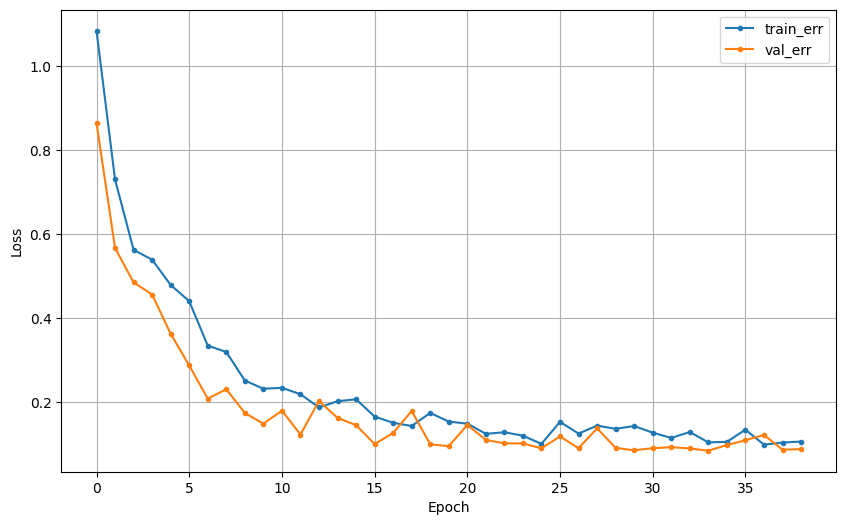

In [51]:
dl_history_plot(historys_3)

In [52]:
preds_3 = models_3.predict(x_val_s)
print(preds_3[:5])

preds_3 = np.where(preds_3 >= .5, 1, 0)
print(preds_3[:5])

pred_labels = np.argmax(preds_3, axis=1)

print(confusion_matrix(y_val_s, pred_labels))
print(classification_report(y_val_s, pred_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[5.89977717e-05 1.20006809e-02 9.87940192e-01]
 [3.68654778e-17 9.99969661e-01 3.03308880e-05]
 [9.99999940e-01 0.00000000e+00 7.24279627e-22]
 [8.47835385e-04 7.06504285e-02 9.28501666e-01]
 [4.00963545e-05 8.83450508e-01 1.16509415e-01]]
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]
[[221   0   0]
 [  0 213   8]
 [  3   8 194]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       221
           1       0.96      0.96      0.96       221
           2       0.96      0.95      0.95       205

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647



In [53]:
clear_session()
models_4 = Sequential([Input(shape=(nfeatures,)),
                     Dense(512, activation='relu'),
                     Dropout(0.1),
                     Dense(512, activation='relu'),
                     Dropout(0.1),
                     Dense(256, activation='relu'),
                     Dropout(0.1),
                     Dense(256, activation='relu'),
                     Dropout(0.1),
                     Dense(128, activation='relu'),
                     Dropout(0.1),
                     Dense(128, activation='relu'),
                     Dropout(0.1),
                     Dense(64, activation='relu'),
                     Dropout(0.1),
                     Dense(64, activation='relu'),
                     Dropout(0.1),
                     Dense(32, activation='relu'),
                     Dropout(0.1),
                     Dense(32, activation='relu'),
                     Dropout(0.1),
                     Dense(3, activation='softmax')])
models_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 812,579 (3.10 MB)

 Trainable params: 812,579 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# 컴파일 및 학습
models_4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historys_4 = models_4.fit(x_train_s, y_train_s, epochs=100, validation_data=(x_val_s, y_val_s), callbacks=[es]).history

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.9350 - val_loss: 0.5071
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5287 - val_loss: 0.4819
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4883 - val_loss: 0.4672
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4663 - val_loss: 0.3808
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4061 - val_loss: 0.2495
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3724 - val_loss: 0.2458
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2277 - val_loss: 0.1549
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3149 - val_loss: 0.1715
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2220 - val_loss: 0.1071
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1581 - val_loss: 0.1041
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1606 - val_loss: 0.1049
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

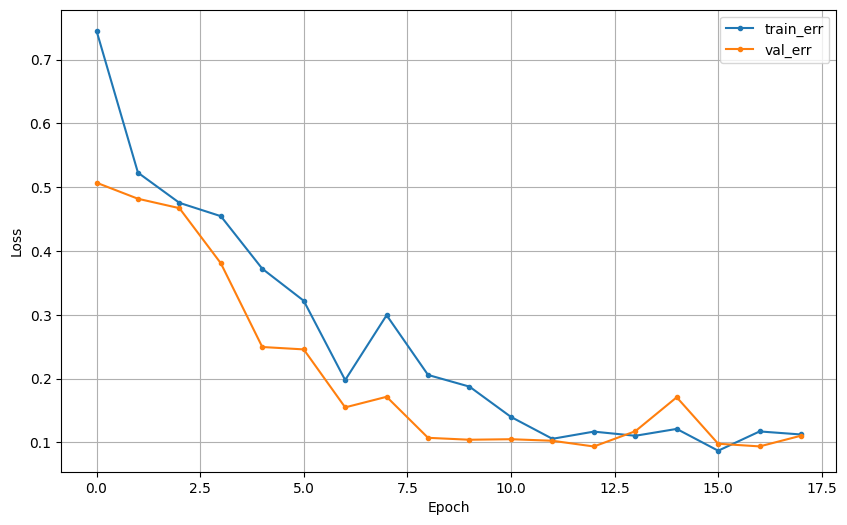

In [55]:
dl_history_plot(historys_4)

In [56]:
preds_4 = models_4.predict(x_val_s)
print(preds_4[:5])

preds_4 = np.where(preds_4 >= .5, 1, 0)
print(preds_4[:5])

pred_labels = np.argmax(preds_4, axis=1)

print(confusion_matrix(y_val_s, pred_labels))
print(classification_report(y_val_s, pred_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
[[1.0923210e-06 6.0103652e-03 9.9398845e-01]
 [2.1362966e-27 9.9995130e-01 4.8669262e-05]
 [9.9999994e-01 5.6111117e-33 6.9850059e-18]
 [4.0929397e-03 1.6890146e-01 8.2700557e-01]
 [3.3641604e-06 7.9237813e-01 2.0761842e-01]]
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]
[[221   0   0]
 [  0 209  12]
 [  0  15 190]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.93      0.95      0.94       221
           2       0.94      0.93      0.93       205

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647



- models_2 0.98
- models_3 0.97
- models_4 0.96
- models_2 가 가장 성능이 좋음

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [57]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [58]:
dynamic = train[train['is_dynamic'] == 1]

In [59]:
dynamic.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1


In [60]:
x_dynamic = dynamic.drop(columns=['Activity', 'is_dynamic'])
y_dynamic = dynamic['Activity']

In [61]:
x_dynamic = scaler.fit_transform(x_dynamic)

In [62]:
x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(x_dynamic, y_dynamic, test_size=0.2, random_state=42)

In [63]:
y_train_d = y_train_d.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})
y_val_d = y_val_d.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})

In [64]:
y_train_d.head()

,Activity
590,1
2485,2
1649,1
2737,2
4533,0


In [65]:
nfeatures = x_train_d.shape[1]

##### base model

In [66]:
clear_session()

model_d = Sequential([Input(shape=(nfeatures,)),
                     Dense(3, activation='softmax')])
model_d.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │           1,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model_d.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

history_d = model_d.fit(x_train_d, y_train_d, epochs=50, validation_data=(x_val_d, y_val_d)).history

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9249 - val_loss: 0.2583
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1885 - val_loss: 0.1986
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1330 - val_loss: 0.1255
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0952 - val_loss: 0.1023
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0762 - val_loss: 0.1101
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0680 - val_loss: 0.1124
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0538 - val_loss: 0.0972
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0647 - val_loss: 0.0607
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0397 - val_loss: 0.0645
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0392 - val_loss: 0.0638
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0316 - val_loss: 0.0454
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0263 - va

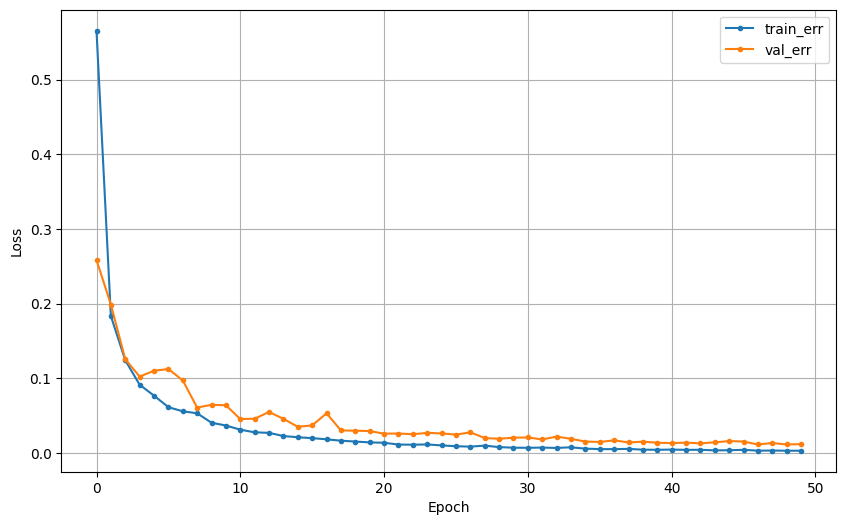

In [68]:
dl_history_plot(history_d)

In [69]:
pred = model_d.predict(x_val_d)
print(pred[:5])

pred = np.where(pred >= .5, 1, 0)
print(pred[:5])

pred_labels = np.argmax(pred, axis=1)

print(confusion_matrix(y_val_d, pred_labels))
print(classification_report(y_val_d, pred_labels))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[9.99735236e-01 1.57745773e-04 1.06971325e-04]
 [3.10820631e-08 3.95070259e-07 9.99999464e-01]
 [2.47738001e-07 1.44210309e-04 9.99855518e-01]
 [9.99999821e-01 1.61121704e-07 6.93245150e-09]
 [1.66745153e-07 5.03200397e-04 9.99496520e-01]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]
[[196   0   0]
 [  1 170   0]
 [  0   0 163]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       196
           1       1.00      0.99      1.00       171
           2       1.00      1.00      1.00       163

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



##### 다양한 모델

In [70]:
clear_session()

modeld_2 = Sequential([Input(shape=(nfeatures,)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(3, activation='softmax')])
modeld_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,883 (1.77 MB)

 Trainable params: 462,883 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# 컴파일 및 학습
modeld_2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historyd_2 = modeld_2.fit(x_train_d, y_train_d, epochs=100, validation_data=(x_val_d, y_val_d), callbacks=[es]).history

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.7378 - val_loss: 1.2341
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3146 - val_loss: 0.5546
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1563 - val_loss: 0.0640
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0310 - val_loss: 0.0879
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0270 - val_loss: 0.0533
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0339 - val_loss: 0.0259
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0330
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0615 - val_loss: 0.0229
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0236 - val_loss: 0.3555
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1090 - val_loss: 0.1251
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss:

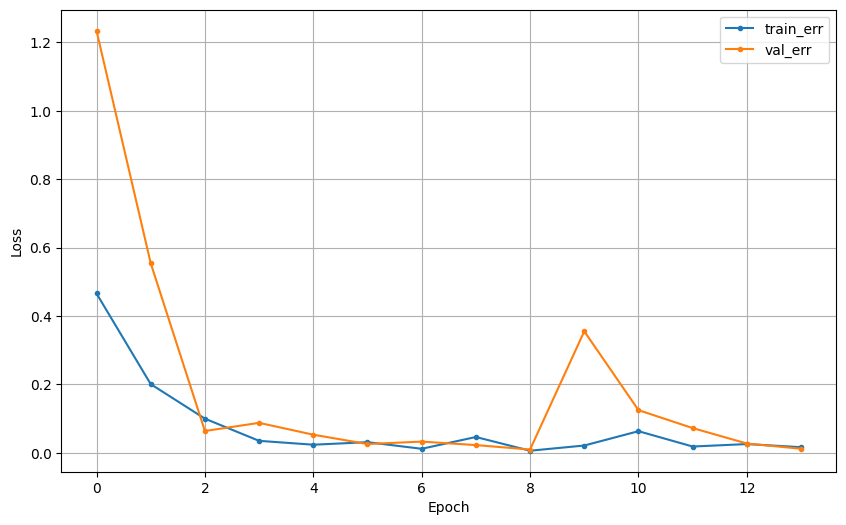

In [72]:
dl_history_plot(historyd_2)

In [73]:
predd_2 = modeld_2.predict(x_val_d)
print(predd_2[:5])

predd_2 = np.where(predd_2 >= .5, 1, 0)
print(predd_2[:5])

pred_labels = np.argmax(predd_2, axis=1)

print(confusion_matrix(y_val_d, pred_labels))
print(classification_report(y_val_d, pred_labels))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[9.98203218e-01 1.38613943e-03 4.10637091e-04]
 [1.49501459e-04 4.29240717e-05 9.99807596e-01]
 [3.57576908e-04 1.89752158e-04 9.99452710e-01]
 [9.99915063e-01 7.20180105e-05 1.28379315e-05]
 [3.13969824e-04 2.01849733e-04 9.99484122e-01]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]
[[195   1   0]
 [  0 171   0]
 [  0   0 163]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       196
           1       0.99      1.00      1.00       171
           2       1.00      1.00      1.00       163

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



In [74]:
clear_session()
modeld_3 = Sequential([Input(shape=(nfeatures,)),
                    Dense(512, activation='relu'),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    Dense(128, activation='relu'),
                    Dropout(0.3),
                    Dense(64, activation='relu'),
                    Dropout(0.3),
                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    Dense(16, activation='relu'),
                    Dropout(0.3),
                    Dense(3, activation='softmax')])
modeld_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,883 (1.77 MB)

 Trainable params: 462,883 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# 컴파일 및 학습
modeld_3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historyd_3 = modeld_3.fit(x_train_d, y_train_d, epochs=100, validation_data=(x_val_d, y_val_d), callbacks=[es]).history

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.1007 - val_loss: 1.0209
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9359 - val_loss: 0.6697
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6806 - val_loss: 0.3586
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4168 - val_loss: 0.1724
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2680 - val_loss: 0.1965
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2605 - val_loss: 0.0664
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1595 - val_loss: 0.1065
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1306 - val_loss: 0.0635
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0899 - val_loss: 0.1656
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0890 - val_loss: 0.0330
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0917 - val_loss: 0.0352
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

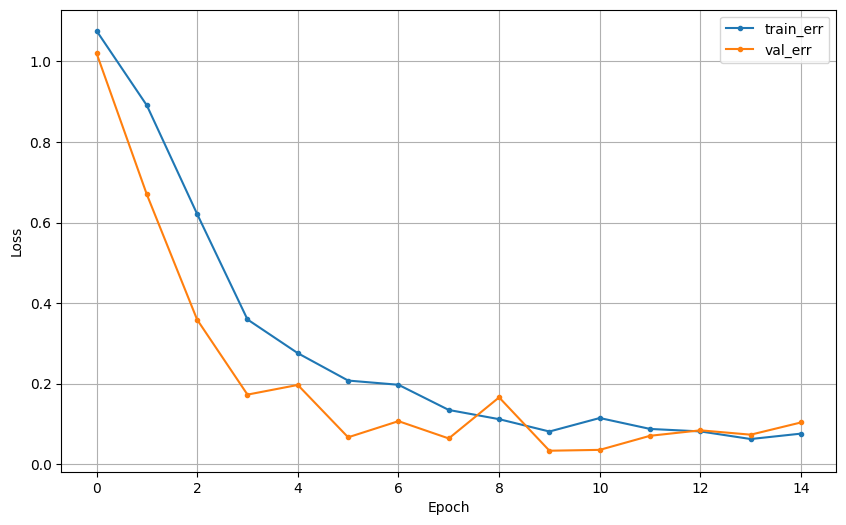

In [76]:
dl_history_plot(historyd_3)

In [77]:
predd_3 = modeld_3.predict(x_val_d)
print(predd_3[:5])

predd_3 = np.where(predd_3 >= .5, 1, 0)
print(predd_3[:5])

pred_labels = np.argmax(predd_3, axis=1)

print(confusion_matrix(y_val_d, pred_labels))
print(classification_report(y_val_d, pred_labels))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[9.9670494e-01 1.0960607e-03 2.1989399e-03]
 [9.6144404e-10 4.1298904e-15 9.9999994e-01]
 [4.5809898e-07 8.3665568e-11 9.9999946e-01]
 [9.9999899e-01 9.2969593e-08 7.8285149e-07]
 [1.6326119e-05 2.5144757e-08 9.9998361e-01]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]
[[195   0   1]
 [ 18 149   4]
 [  0   0 163]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       196
           1       1.00      0.87      0.93       171
           2       0.97      1.00      0.98       163

    accuracy                           0.96       530
   macro avg       0.96      0.96      0.96       530
weighted avg       0.96      0.96      0.96       530



In [78]:
clear_session()
modeld_4 = Sequential([Input(shape=(nfeatures,)),
                     Dense(512, activation='relu'),
                     Dropout(0.1),
                     Dense(512, activation='relu'),
                     Dropout(0.1),
                     Dense(256, activation='relu'),
                     Dropout(0.1),
                     Dense(256, activation='relu'),
                     Dropout(0.1),
                     Dense(128, activation='relu'),
                     Dropout(0.1),
                     Dense(128, activation='relu'),
                     Dropout(0.1),
                     Dense(64, activation='relu'),
                     Dropout(0.1),
                     Dense(64, activation='relu'),
                     Dropout(0.1),
                     Dense(32, activation='relu'),
                     Dropout(0.1),
                     Dense(32, activation='relu'),
                     Dropout(0.1),
                     Dense(3, activation='softmax')])
modeld_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 812,579 (3.10 MB)

 Trainable params: 812,579 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# 컴파일 및 학습
modeld_4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
patience = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = patience)

historyd_4 = modeld_4.fit(x_train_d, y_train_d, epochs=100, validation_data=(x_val_d, y_val_d), callbacks=[es]).history

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.0470 - val_loss: 0.5423
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4912 - val_loss: 0.4041
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3591 - val_loss: 0.1947
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1328 - val_loss: 0.0596
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0755 - val_loss: 0.2335
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0800 - val_loss: 0.1266
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1172 - val_loss: 0.0730
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0333 - val_loss: 0.0602
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0365 - val_loss: 0.0734


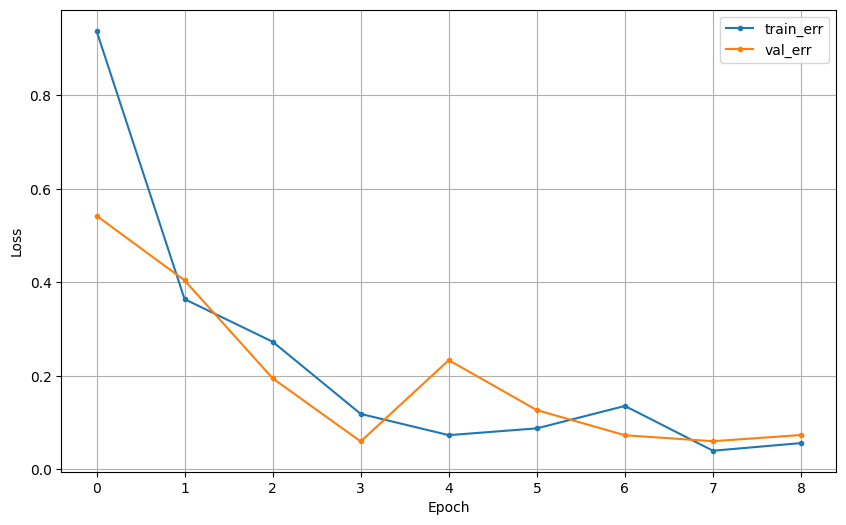

In [80]:
dl_history_plot(historyd_4)

In [81]:
predd_4 = modeld_4.predict(x_val_d)
print(predd_4[:5])

predd_4 = np.where(predd_4 >= .5, 1, 0)
print(predd_4[:5])

pred_labels = np.argmax(predd_4, axis=1)

print(confusion_matrix(y_val_d, pred_labels))
print(classification_report(y_val_d, pred_labels))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[[8.6783653e-01 7.5231262e-02 5.6932174e-02]
 [3.7312937e-08 5.7150432e-06 9.9999422e-01]
 [5.6067283e-06 2.1085293e-04 9.9978352e-01]
 [9.9998969e-01 6.6541506e-06 3.6353474e-06]
 [3.1931377e-05 7.5305719e-04 9.9921507e-01]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]
[[192   0   4]
 [  4 162   5]
 [  0   0 163]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       196
           1       1.00      0.95      0.97       171
           2       0.95      1.00      0.97       163

    accuracy                           0.98       530
   macro avg       0.98      0.98      0.98       530
weighted avg       0.98      0.98      0.98       530



- model_d base 1
- modeld_2 1
- modeld_3 0.96
- modeld_4 0.98

### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [82]:
from sklearn.preprocessing import MinMaxScaler

def model_complete(model_b, models_2, model_d, data, test_data):
    # is_dynamic을 정의하고 이를 목표로 삼아 데이터 분리
    data['is_dynamic'] = data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

    # 'is_dynamic', 'Activity', 'pred1' 열을 제거하여 모델 입력 데이터 준비
    x = data.drop(columns=['is_dynamic', 'Activity']).values  # NumPy 배열로 변환
    y = data['is_dynamic']

    # 스케일링 재학습 (pred1 없이 스케일링)
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)  # 스케일링을 다시 학습

    print(f"Input shape to model_b: {x_scaled.shape}")  # (1471, 561)

    # 첫 번째 모델(정적/동적)을 사용하여 예측
    pred1 = model_b.predict(x_scaled)
    pred1 = np.where(pred1 > 0.5, 1, 0)
    data['pred1'] = pred1  # 예측 결과를 데이터에 추가

    # 정적 상태 데이터 (is_dynamic == 0) 추출 및 예측
    static = data[data['is_dynamic'] == 0]
    x_static = static.drop(columns=['is_dynamic', 'Activity', 'pred1']).values  # NumPy 배열로 변환
    y_static = static['Activity']

    print(f"x_static shape after removing columns: {x_static.shape}")

    # 스케일링 적용
    x_static = scaler.transform(x_static)  # 스케일링 후 적용
    print(f"Scaled x_static shape: {x_static.shape}")

    # 정적 상태 모델 예측
    pred2 = models_2.predict(x_static)
    print(f"Predicted shape from models_2: {pred2.shape}")

    pred2 = pred2.argmax(axis=1)
    static['pred2'] = pred2
    static['pred2'] = static['pred2'].map({0: 'LAYING', 1: 'STANDING', 2: 'SITTING'})

    # 동적 상태 데이터 (is_dynamic == 1) 추출 및 예측
    dynamic = data[data['is_dynamic'] == 1]
    x_dynamic = dynamic.drop(columns=['is_dynamic', 'Activity', 'pred1']).values
    y_dynamic = dynamic['Activity']

    print(f"x_dynamic shape after removing columns: {x_dynamic.shape}")

    # 스케일링 적용
    x_dynamic = scaler.transform(x_dynamic)
    print(f"Scaled x_dynamic shape: {x_dynamic.shape}")

    # 동적 상태 모델 예측
    pred3 = model_d.predict(x_dynamic)
    print(f"Predicted shape from model_d: {pred3.shape}")

    pred3 = pred3.argmax(axis=1)
    dynamic['pred3'] = pred3
    dynamic['pred3'] = dynamic['pred3'].map({0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS'})

    # 결과 병합
    result_static = static[['pred2', 'Activity']]
    result_dynamic = dynamic[['pred3', 'Activity']]
    result_static.columns = ['Prediction', 'Activity']
    result_dynamic.columns = ['Prediction', 'Activity']
    result = pd.concat([result_static, result_dynamic], axis=0)

    # 성능 평가
    print('Accuracy:', accuracy_score(result['Activity'], result['Prediction']))
    print('='*60)
    print(confusion_matrix(result['Activity'], result['Prediction']))
    print('='*60)
    print(classification_report(result['Activity'], result['Prediction']))

    return result


#### 2) test 셋으로 예측하고 평가하기

In [83]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [84]:
pred = model_complete(model_b, models_2, model_d, train, test)

print(pred)

Input shape to model_b: (5881, 561)
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
x_static shape after removing columns: (3234, 561)
Scaled x_static shape: (3234, 561)
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted shape from models_2: (3234, 3)
x_dynamic shape after removing columns: (2647, 561)
Scaled x_dynamic shape: (2647, 561)
 1/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step

<ipython-input-82-897e99903baa>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static['pred2'] = pred2
<ipython-input-82-897e99903baa>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static['pred2'] = static['pred2'].map({0: 'LAYING', 1: 'STANDING', 2: 'SITTING'})


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicted shape from model_d: (2647, 3)
Accuracy: 0.9806155415745621
[[1115    0    0    0    0    0]
 [   3 1014   15    0    0    0]
 [   0   63 1024    0    0    0]
 [   0    0    0  975    6   17]
 [   0    0    0    0  781   10]
 [   0    0    0    0    0  858]]


<ipython-input-82-897e99903baa>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dynamic['pred3'] = pred3
<ipython-input-82-897e99903baa>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dynamic['pred3'] = dynamic['pred3'].map({0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS'})


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00      1115
           SITTING       0.94      0.98      0.96      1032
          STANDING       0.99      0.94      0.96      1087
           WALKING       1.00      0.98      0.99       998
WALKING_DOWNSTAIRS       0.99      0.99      0.99       791
  WALKING_UPSTAIRS       0.97      1.00      0.98       858

          accuracy                           0.98      5881
         macro avg       0.98      0.98      0.98      5881
      weighted avg       0.98      0.98      0.98      5881

            Prediction          Activity
0             STANDING          STANDING
1               LAYING            LAYING
2             STANDING          STANDING
7              SITTING          STANDING
8             STANDING          STANDING
...                ...               ...
5868           WALKING           WALKING
5869  WALKING_UPSTAIRS  WALKING_UPSTAIRS
5873           WALKING      